In [1]:
import os, sys, glob
import pandas as` pd
import numpy as np
import pickle
import warnings
from process_mmrf import get_sequential_tensor, merge_on_pids, parse_baseline, parse_outcomes, parse_treatments, parse_labs, parse_trt_outcomes
from fancyimpute import KNN as KNN_impute

Using TensorFlow backend.
/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [2]:
ia_version = 'ia15'
if ia_version == 'ia15': 
    FDIR  = '/afs/csail.mit.edu/group/clinicalml/datasets/multiple_myeloma/ia15/CoMMpass_IA15_FlatFiles'
elif ia_version == 'ia13':
    FDIR  = '/afs/csail.mit.edu/group/clinicalml/datasets/multiple_myeloma/ia13/CoMMpass_IA13_FlatFiles'
elif ia_version == 'ia12':
    FDIR  = '/afs/csail.mit.edu/group/clinicalml/datasets/multiple_myeloma/ia12/CoMMpass_IA12_FlatFiles'
else:
    raise ValueError('Bad ia version')

In [3]:
data_files = {}
for fullname in glob.glob(FDIR+'/*.csv'):
    print (fullname)
    fname = os.path.basename(fullname).split('.')[0]
    if 'MMRF_CoMMpass_IA15_' in fname:
        kname = fname.split('MMRF_CoMMpass_IA15_')[1]
    else:
        kname = fname
    data_files[kname] = pd.read_csv(fullname, delimiter=',', encoding='latin-1')
print (data_files.keys())

/afs/csail.mit.edu/group/clinicalml/datasets/multiple_myeloma/ia15/CoMMpass_IA15_FlatFiles/MMRF_CoMMpass_IA15_STAND_ALONE_EMERGENCY_DEPT.csv
/afs/csail.mit.edu/group/clinicalml/datasets/multiple_myeloma/ia15/CoMMpass_IA15_FlatFiles/MMRF_CoMMpass_IA15_PER_PATIENT_VISIT.csv


/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5,9,11,12,13,14,15,16,17,18,23,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,47,49,50,51,52,55,57,58,60,61,62,63,64,66,68,70,71,73,75,76,77,78,79,80,83,84,85,87,90,91,92,94,97,98,99,100,101,103,106,107,108,110,113,114,115,117,120,121,122,126,127,128,130,132,133,138,139,141,142,143,144,145,147,148,149,150,151,152,153,155,156,157,158,159,160,161,162,163,165,166,167,168,169,170,177,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,218,224,225,226,227,232,233,242,245,248,251,274,279,291,292,378,380,421,424,426,428,431,433,435,438,440,442,445,447,449,450,451,453,455,457,458,459,460,461,462,463,464,465,466,467,468,469,470,472,475,478,480,482,485,487,489,492,494,496,499,501,503,506,508,510,513,515,517,520,522,524,527,529,531,534,536,538,541,543,545

/afs/csail.mit.edu/group/clinicalml/datasets/multiple_myeloma/ia15/CoMMpass_IA15_FlatFiles/MMRF_CoMMpass_IA15_STAND_ALONE_TRTRESP.csv
/afs/csail.mit.edu/group/clinicalml/datasets/multiple_myeloma/ia15/CoMMpass_IA15_FlatFiles/MMRF_CoMMpass_IA15_STAND_ALONE_TREATMENT_REGIMEN.csv
/afs/csail.mit.edu/group/clinicalml/datasets/multiple_myeloma/ia15/CoMMpass_IA15_FlatFiles/MMRF_CoMMpass_IA15_STAND_ALONE_AE.csv
/afs/csail.mit.edu/group/clinicalml/datasets/multiple_myeloma/ia15/CoMMpass_IA15_FlatFiles/MMRF_CoMMpass_IA15_STAND_ALONE_FAMHX.csv
/afs/csail.mit.edu/group/clinicalml/datasets/multiple_myeloma/ia15/CoMMpass_IA15_FlatFiles/MMRF_CoMMpass_IA15_STAND_ALONE_MEDHX.csv
/afs/csail.mit.edu/group/clinicalml/datasets/multiple_myeloma/ia15/CoMMpass_IA15_FlatFiles/MMRF_CoMMpass_IA15_STAND_ALONE_ADMISSIONS.csv
/afs/csail.mit.edu/group/clinicalml/datasets/multiple_myeloma/ia15/CoMMpass_IA15_FlatFiles/MMRF_CoMMpass_IA15_STAND_ALONE_SURVIVAL.csv
/afs/csail.mit.edu/group/clinicalml/datasets/multiple_mye

/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (24,28,44,74,75,80,81,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
ypid_trt, Ytrt, tr_names = parse_trt_outcomes(data_files['STAND_ALONE_TRTRESP'], from_gateway=True)

> /afs/csail.mit.edu/u/z/zeshanmh/research/ief/data/ml_mmrf/ml_mmrf_v1/process_mmrf.py(296)parse_trt_outcomes()
-> pd_pids    = pd.read_csv('./cohorts/pd_line2.csv')


(Pdb)  c


parse_outcomes (from MMRF gateway):  (359,) (359,)


In [4]:
ppv_df = data_files['PER_PATIENT_VISIT']
ppv_df.columns.values
ppv_df[['PUBLIC_ID', 'VISIT', 'D_LAB_serum_m_protein','D_LAB_urine_24hr_m_protein']]

,PUBLIC_ID,VISIT,D_LAB_serum_m_protein,D_LAB_urine_24hr_m_protein
0,MMRF_1014,-1.0,NaN,NaN
1,MMRF_1014,0.0,2.2,NaN
2,MMRF_1014,1.0,NaN,NaN
3,MMRF_1014,2.0,1.4,NaN
4,MMRF_1014,3.0,1.4,NaN
...,...,...,...,...
18290,MMRF_2853,2.0,NaN,NaN
18291,MMRF_2853,2.0,NaN,NaN
18292,MMRF_2853,2.0,NaN,NaN
18293,MMRF_2853,3.0,NaN,NaN


In [5]:
per_patient_df = data_files['PER_PATIENT']

##race 
race = per_patient_df[['DEMOG_GENDER','DEMOG_AMERICANINDIA', 'DEMOG_ASIAN', 'DEMOG_BLACKORAFRICA', 'DEMOG_NATIVEHAWAIIA', 'DEMOG_WHITE', 'DEMOG_OTHER']]
print(f'total number of people: {len(race.index)}')
w    = race[race['DEMOG_WHITE'] == 'Checked']
b    = race[race['DEMOG_BLACKORAFRICA'] == 'Checked' ]
n    = race[race['DEMOG_NATIVEHAWAIIA'] == 'Checked' ]
na    = race[race['DEMOG_AMERICANINDIA'] == 'Checked' ]
a    = race[race['DEMOG_ASIAN'] == 'Checked' ]
o    = race[race['DEMOG_OTHER'] == 'Checked' ]
print(f'Race: WHITE, Count: {len(w.index)}, Percent: {len(w.index)/len(race.index):.3f}')
print(f'Race: BLACK OR AFRICAN AMERICAN, Count: {len(b.index)}, Percent: {len(b.index)/len(race.index):.3f}')
print(f'Race: ASIAN, Count: {len(a.index)}, Percent: {len(a.index)/len(race.index):.3f}')
print(f'Race: NATIVE AMERICAN, Count: {len(na.index)}, Percent: {len(na.index)/len(race.index):.3f}')
print(f'Race: NATIVE HAWAIIN, Count: {len(n.index)}, Percent: {len(n.index)/len(race.index):.3f}')
print(f'Race: OTHER, Count: {len(o.index)}, Percent: {len(o.index)/len(race.index):.3f}')
print(f'Race: NA, Count: 168, Percent: {168/len(race.index):.3f}')



total number of people: 1143
Race: WHITE, Count: 742, Percent: 0.649
Race: BLACK OR AFRICAN AMERICAN, Count: 161, Percent: 0.141
Race: ASIAN, Count: 18, Percent: 0.016
Race: NATIVE AMERICAN, Count: 4, Percent: 0.003
Race: NATIVE HAWAIIN, Count: 0, Percent: 0.000
Race: OTHER, Count: 50, Percent: 0.044
Race: NA, Count: 168, Percent: 0.147


/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [8]:
ethnicity = per_patient_df[['DEMOG_ETHNICITY']]
h = ethnicity[ethnicity['DEMOG_ETHNICITY'] == 'Hispanic or Latino']
n = ethnicity[ethnicity['DEMOG_ETHNICITY'] == 'Not Hispanic or Latino']
o = ethnicity[ethnicity['DEMOG_ETHNICITY'] == 'Other']
print(f'Ethnicity: Hispanic or Latino, Count: {len(h.index)}, Percent: {len(h.index)/len(ethnicity.index):.3f}')
print(f'Ethnicity: Not Hispanic or Latino, Count: {len(n.index)}, Percent: {len(n.index)/len(ethnicity.index):.3f}')
print(f'Ethnicity: Other, Count: {len(o.index)}, Percent: {len(o.index)/len(ethnicity.index):.3f}')
print(f'Ethnicity: NA, Count: {1143-(76+861+34)}, Percent: {172/1143:.3f}')

Ethnicity: Hispanic or Latino, Count: 76, Percent: 0.066
Ethnicity: Not Hispanic or Latino, Count: 861, Percent: 0.753
Ethnicity: Other, Count: 34, Percent: 0.030
Ethnicity: NA, Count: 172, Percent: 0.150


In [7]:
m    = race[race['DEMOG_GENDER'] == 'Male']
f    = race[race['DEMOG_GENDER'] == 'Female']
print(f'Gender: MALE, Count: {len(m.index)}, Percent: {len(m.index)/len(race.index):.3f}')
print(f'Gender: FEMALE, Count: {len(f.index)}, Percent: {len(f.index)/len(race.index):.3f}')
print(f'Gender: NA, Count: {1143-(587+384)}, Percent: {172/len(race.index):.3f}')


Gender: MALE, Count: 587, Percent: 0.514
Gender: FEMALE, Count: 384, Percent: 0.336
Gender: NA, Count: 172, Percent: 0.150


age available, count: 1143


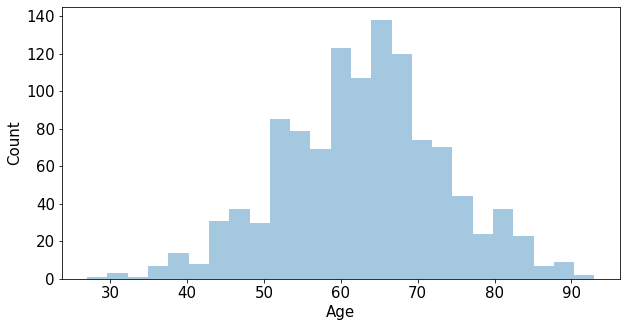

In [66]:
age = per_patient_df[['D_PT_age']]
print(f"age available, count: {len(age[age['D_PT_age'].notna()].index)}")
import seaborn as sns
import matplotlib.pylab as plt
fig, ax = plt.subplots(figsize=(10,5))
a1 = sns.distplot(age,ax=ax, hist=True, kde=False)
a1.set_xlabel('Age', fontsize=15)
a1.set_ylabel('Count', fontsize=15)
a1.tick_params(axis='x', labelsize=15)
a1.tick_params(axis='y', labelsize=15)

In [74]:
iss = per_patient_df[['D_PT_iss']]
riss =per_patient_df[['R_ISS']]
s1 = iss[iss['D_PT_iss'] == 1.]
s2 = iss[iss['D_PT_iss'] == 2.]
s3 = iss[iss['D_PT_iss'] == 3.]

print(f'ISS Stage: 1, Count: {len(s1.index)}, Percent: {len(s1.index)/len(iss.index):.3f}')
print(f'ISS Stage: 2, Count: {len(s2.index)}, Percent: {len(s2.index)/len(iss.index):.3f}')
print(f'ISS Stage: 3, Count: {len(s3.index)}, Percent: {len(s3.index)/len(iss.index):.3f}')
print(f'ISS Stage: NA, Count: 30, Percent: {30/len(iss.index):.3f}')

r1 = riss[riss['R_ISS'] == 1.]
r2 = riss[riss['R_ISS'] == 2.]
r3 = riss[riss['R_ISS'] == 3.]
print()
print(f'rISS Stage: 1, Count: {len(r1.index)}, Percent: {len(r1.index)/len(riss.index):.3f}')
print(f'rISS Stage: 2, Count: {len(r2.index)}, Percent: {len(r2.index)/len(riss.index):.3f}')
print(f'rISS Stage: 3, Count: {len(r3.index)}, Percent: {len(r3.index)/len(riss.index):.3f}')
print(f'rISS Stage: NA, Count: 453, Percent: {453/len(iss.index):.3f}')


ISS Stage: 1, Count: 401, Percent: 0.351
ISS Stage: 2, Count: 401, Percent: 0.351
ISS Stage: 3, Count: 311, Percent: 0.272
ISS Stage: NA, Count: 30, Percent: 0.026

rISS Stage: 1, Count: 170, Percent: 0.149
rISS Stage: 2, Count: 445, Percent: 0.389
rISS Stage: 3, Count: 75, Percent: 0.066
rISS Stage: NA, Count: 453, Percent: 0.396


In [8]:
trt_df = data_files['STAND_ALONE_TRTRESP']
temp   = trt_df[(trt_df['line'] == 1) & (trt_df['frespdy'] >= trt_df['trtstdy']) & (trt_df['frespdy'] <= trt_df['trtendy'])]
fresp  = temp[['public_id', 'trtshnm', 'frespsh']]

# proportion of each thing 
print(fresp)
print
print(len(fresp[fresp['frespsh'] == 'sCR'].index))
print(len(fresp[fresp['frespsh'] == 'CR'].index))
print(len(fresp[fresp['frespsh'] == 'VGPR'].index))
print(len(fresp[fresp['frespsh'] == 'PR'].index))
print(len(fresp[fresp['frespsh'] == 'SD'].index))
print(len(fresp[fresp['frespsh'] == 'PD'].index))

temp  = trt_df[(trt_df['line'] == 1) & (trt_df['trtstdy'] == trt_df['therstdy']) & (trt_df['bestrespsh'].notna())]
bresp = temp[['public_id', 'trtshnm', 'bestrespsh']]

print(bresp)
print
print(len(bresp[bresp['bestrespsh'] == 'sCR'].index))
print(len(bresp[bresp['bestrespsh'] == 'CR'].index))
print(len(bresp[bresp['bestrespsh'] == 'VGPR'].index))
print(len(bresp[bresp['bestrespsh'] == 'PR'].index))
print(len(bresp[bresp['bestrespsh'] == 'SD'].index))
print(len(bresp[bresp['bestrespsh'] == 'PD'].index))

      public_id      trtshnm frespsh
10    MMRF_1014      Bor-Dex      PR
14    MMRF_1017      Len-Dex      PR
19    MMRF_1038      Len-Dex      PR
20    MMRF_1033      Len-Dex      PR
26    MMRF_1052          Bor      PR
...         ...          ...     ...
3249  MMRF_2843  Car-Len-Dex      PR
3252  MMRF_2847  Car-Len-Dex      PR
3254  MMRF_2848  Car-Len-Dex      PR
3256  MMRF_2851  Car-Cyc-Dex    VGPR
3257  MMRF_2853  Car-Len-Dex      PR

[851 rows x 3 columns]
6
12
323
510
0
0
      public_id        trtshnm bestrespsh
0     MMRF_1014        Bor-Dex         PR
14    MMRF_1017        Len-Dex       VGPR
15    MMRF_1024  Thal-Mel-Pred         SD
19    MMRF_1038        Len-Dex         PR
20    MMRF_1033        Len-Dex         PR
...         ...            ...        ...
3249  MMRF_2843    Car-Len-Dex         PR
3252  MMRF_2847    Car-Len-Dex         PR
3254  MMRF_2848    Car-Len-Dex       VGPR
3256  MMRF_2851    Car-Cyc-Dex       VGPR
3257  MMRF_2853    Car-Len-Dex       VGPR

[1074 rows

In [5]:
# we have best response and first response to first line therapy (can restrict first line therapy further if we wish)
# we want to ask the Q: for patients who have del17p vs not, is there a difference in their responses to first line therapy? 
per_patient = data_files['PER_PATIENT']
genetic = per_patient[['PUBLIC_ID', 'Cp_17p13_Call', 'UAMS_Ratio', 'Prolif_Index', 'IMWG_Risk_Class', 'TP53_Funct_Copies']]
print(genetic)

del17 = genetic[genetic['Cp_17p13_Call'].notna()][['PUBLIC_ID', 'Cp_17p13_Call']]
del17 = del17.rename(columns = {'PUBLIC_ID': 'public_id'})
del17p_bresp = pd.merge(del17, bresp, how='inner', on='public_id')

      PUBLIC_ID  Cp_17p13_Call  UAMS_Ratio  Prolif_Index  IMWG_Risk_Class  \
0     MMRF_1014            NaN         NaN           NaN              NaN   
1     MMRF_1017            NaN         NaN           NaN              NaN   
2     MMRF_1024            NaN    0.161083      1.515921              NaN   
3     MMRF_1038            NaN    0.169745      2.048673              NaN   
4     MMRF_1033            0.0    0.093860      1.565463              0.0   
...         ...            ...         ...           ...              ...   
1138  MMRF_2846            NaN         NaN           NaN              NaN   
1139  MMRF_2847            NaN         NaN           NaN              NaN   
1140  MMRF_2848            NaN         NaN           NaN              NaN   
1141  MMRF_2851            NaN         NaN           NaN              NaN   
1142  MMRF_2853            NaN         NaN           NaN              NaN   

      TP53_Funct_Copies  
0                   NaN  
1                   NaN

In [10]:
# we want to ask the Q: for patients who have del17p vs not, is there a difference in their (first and best) responses to first line therapy? 
nodel = del17p_bresp[del17p_bresp['Cp_17p13_Call'] == 0.0]
delp  = del17p_bresp[del17p_bresp['Cp_17p13_Call'] != 0.0]
print(nodel)
print(delp)

print('Cohort without 17p deletion (N=606):')
print(f'proportion of people that had sCR: {len(nodel[nodel["bestrespsh"] == "sCR"].index)/ 606}')
print(f'proportion of people that had CR: {len(nodel[nodel["bestrespsh"] == "CR"].index)/ 606}')
print(f'proportion of people that had VGPR: {len(nodel[nodel["bestrespsh"] == "VGPR"].index)/ 606}')
print(f'proportion of people that had PR: {len(nodel[nodel["bestrespsh"] == "PR"].index)/ 606}')
print(f'proportion of people that had SD: {len(nodel[nodel["bestrespsh"] == "SD"].index)/ 606}')
print(f'proportion of people that had PD: {len(nodel[nodel["bestrespsh"] == "PD"].index)/ 606}')
print()
# print(len(delp[delp['bestrespsh'] == 'SCR'].index) / 77)
print('Cohort with 17p deletion (N=77):')
print(f'proportion of people that had sCR: {len(delp[delp["bestrespsh"] == "sCR"].index)/ 77}')
print(f'proportion of people that had CR: {len(delp[delp["bestrespsh"] == "CR"].index)/ 77}')
print(f'proportion of people that had VGPR: {len(delp[delp["bestrespsh"] == "VGPR"].index)/ 77}')
print(f'proportion of people that had PR: {len(delp[delp["bestrespsh"] == "PR"].index)/ 77}')
print(f'proportion of people that had SD: {len(delp[delp["bestrespsh"] == "SD"].index)/ 77}')
print(f'proportion of people that had PD: {len(delp[delp["bestrespsh"] == "PD"].index)/ 77}')

     public_id  Cp_17p13_Call       trtshnm bestrespsh
0    MMRF_1033            0.0       Len-Dex         PR
1    MMRF_1082            0.0  Bor-Thal-Dex       VGPR
2    MMRF_1129            0.0       Len-Dex       VGPR
3    MMRF_1178            0.0       Bor-Dex       VGPR
4    MMRF_1285            0.0   Bor-Cyc-Dex       VGPR
..         ...            ...           ...        ...
678  MMRF_2268            0.0  Bor-Mel-Pred       VGPR
679  MMRF_2305            0.0  Bor-Cyc-Pred       VGPR
680  MMRF_2444            0.0  Bor-Mel-Pred       VGPR
681  MMRF_2195            0.0  Bor-Mel-Pred         PR
682  MMRF_2317            0.0  Bor-Mel-Pred         PR

[606 rows x 4 columns]
     public_id  Cp_17p13_Call           trtshnm bestrespsh
8    MMRF_1670            1.0       Bor-Len-Dex         PR
21   MMRF_2579            1.0       Bor-Len-Dex         CR
28   MMRF_1286            1.0       Bor-Len-Dex         SD
40   MMRF_1491            1.0           Len-Dex         PR
52   MMRF_1758       

In [45]:
def check_tr_het(df, mol_key, mol_str, verbose=False): 
    t11 = df[['PUBLIC_ID', mol_key]]
    t11_final = t11[t11[mol_key].notna()]

    t11_final = t11_final.rename(columns={'PUBLIC_ID': 'public_id'})


    t11_not = t11_final[t11_final[mol_key] == 'No']
    t11_not = t11_not.drop_duplicates()
    t11_yes = t11_final[t11_final[mol_key] == 'Yes']
    t11_yes = t11_yes.drop_duplicates()

    t11_bresp_no  = pd.merge(t11_not, bresp, how='inner', on='public_id')
    t11_bresp_yes = pd.merge(t11_yes, bresp, how='inner', on='public_id')
    if verbose: 
        print(t11_bresp_no)
        print(t11_bresp_yes)
    Nno  = len(t11_bresp_no.index)
    Nyes = len(t11_bresp_yes.index)
    
    print(f'Cohort without {mol_str} (N={Nno}):')
    print(f'proportion of people that had sCR: {len(t11_bresp_no[t11_bresp_no["bestrespsh"] == "sCR"].index)/ Nno}')
    print(f'proportion of people that had CR: {len(t11_bresp_no[t11_bresp_no["bestrespsh"] == "CR"].index)/ Nno}')
    print(f'proportion of people that had VGPR: {len(t11_bresp_no[t11_bresp_no["bestrespsh"] == "VGPR"].index)/ Nno}')
    print(f'proportion of people that had PR: {len(t11_bresp_no[t11_bresp_no["bestrespsh"] == "PR"].index)/ Nno}')
    print(f'proportion of people that had SD: {len(t11_bresp_no[t11_bresp_no["bestrespsh"] == "SD"].index)/ Nno}')
    print(f'proportion of people that had PD: {len(t11_bresp_no[t11_bresp_no["bestrespsh"] == "PD"].index)/ Nno}')
    print()
    # print(len(delp[delp['bestrespsh'] == 'SCR'].index) / 77)
    print(f'Cohort with {mol_str} (N={Nyes}):')
    print(f'proportion of people that had sCR: {len(t11_bresp_yes[t11_bresp_yes["bestrespsh"] == "sCR"].index)/ Nyes}')
    print(f'proportion of people that had CR: {len(t11_bresp_yes[t11_bresp_yes["bestrespsh"] == "CR"].index)/ Nyes}')
    print(f'proportion of people that had VGPR: {len(t11_bresp_yes[t11_bresp_yes["bestrespsh"] == "VGPR"].index)/ Nyes}')
    print(f'proportion of people that had PR: {len(t11_bresp_yes[t11_bresp_yes["bestrespsh"] == "PR"].index)/ Nyes}')
    print(f'proportion of people that had SD: {len(t11_bresp_yes[t11_bresp_yes["bestrespsh"] == "SD"].index)/ Nyes}')
    print(f'proportion of people that had PD: {len(t11_bresp_yes[t11_bresp_yes["bestrespsh"] == "PD"].index)/ Nyes}')
    print('-------------------------------------------------------')

In [51]:
per_patient_visit = data_files['PER_PATIENT_VISIT']
check_tr_het(per_patient_visit, 'D_TRI_CF_ABNORMALITYPR6', 't(11;14)')
check_tr_het(per_patient_visit, 'D_TRI_CF_ABNORMALITYPR3', 't(4;14)')
check_tr_het(per_patient_visit, 'D_TRI_CF_ABNORMALITYPR2', 'del17')
check_tr_het(per_patient_visit, 'D_TRI_CF_ABNORMAILITYP', 'p53 locus mutation')
check_tr_het(per_patient_visit, 'D_TRI_CF_ABNORMALITYPR12', '1pdel ')
check_tr_het(per_patient_visit, 'D_TRI_CF_ABNORMALITYPR13', '1qamp')
check_tr_het(per_patient_visit, 'D_TRI_CF_ABNORMALITYPR4', 't(6;14)')
check_tr_het(per_patient_visit, 'D_TRI_CF_ABNORMALITYPR5', 't(8;14)')
check_tr_het(per_patient_visit, 'D_TRI_CF_ABNORMALITYPR7', 't(12;14)')
check_tr_het(per_patient_visit, 'D_TRI_CF_ABNORMALITYPR8', 't(14;16)')
check_tr_het(per_patient_visit, 'D_TRI_CF_ABNORMALITYPR9', 't(14;20)')



Cohort without t(11;14) (N=743):
proportion of people that had sCR: 0.06594885598923284
proportion of people that had CR: 0.19650067294751009
proportion of people that had VGPR: 0.5235531628532974
proportion of people that had PR: 0.1601615074024226
proportion of people that had SD: 0.047106325706594884
proportion of people that had PD: 0.006729475100942127

Cohort with t(11;14) (N=224):
proportion of people that had sCR: 0.05357142857142857
proportion of people that had CR: 0.20535714285714285
proportion of people that had VGPR: 0.5223214285714286
proportion of people that had PR: 0.15178571428571427
proportion of people that had SD: 0.05803571428571429
proportion of people that had PD: 0.008928571428571428
-------------------------------------------------------
Cohort without t(4;14) (N=770):
proportion of people that had sCR: 0.06233766233766234
proportion of people that had CR: 0.19090909090909092
proportion of people that had VGPR: 0.5194805194805194
proportion of people that had 

In [ ]:
D_TRI_CF_ABNORMALITYPR12

## Determining if urine 24h M-protein and serum M-protein are sufficient

In [4]:
dataset = {}
dataset['treatment'] = {}
dataset['labs']      = {}
dataset['baseline']  = {}
dataset['outcomes']  = {}
dataset['trt_outcomes'] = {}

dataset_2mos = {}
dataset_2mos['treatment'] = {}
dataset_2mos['labs']      = {}
dataset_2mos['baseline']  = {}
dataset_2mos['outcomes']  = {}
dataset_2mos['trt_outcomes'] = {}

In [5]:
lpids, ldata, lobs, lnames = parse_labs(data_files['PER_PATIENT_VISIT'], granularity = 60, maxT=33)
dataset_2mos['labs']['pids'] = lpids; dataset_2mos['labs']['data']  = ldata
dataset_2mos['labs']['obs']  = lobs;  dataset_2mos['labs']['names'] = lnames

/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

parse_labs: clipped values to 5x median (before/after)
                           0         1
cbc_abs_neut         75.000   19.5000
chem_albumin         55.000   55.0000
chem_bun             52.122   33.5600
chem_calcium         10.300   10.3000
chem_creatinine    1986.348  433.7400
chem_glucose         36.245   32.7750
cbc_hemoglobin       11.656   11.6560
serum_kappa      455000.000   14.6500
serum_m_protein      40.300    5.5000
cbc_platelet        732.000  732.0000
chem_totprot         17.100   17.1000
cbc_wbc              81.000   29.5000
serum_iga           276.630    9.1500
serum_igg           147.000   48.9000
serum_igm            84.200    6.3875
serum_lambda      46200.000   11.4500

parse_labs:processing... 0 cbc_abs_neut
	tget_sequential_tensor: output shapes: (1143,) (1143, 33) (1143, 33)

parse_labs:processing... 1 chem_albumin
	tget_sequential_tensor: output shapes: (1143,) (1143, 33) (1143, 33)

parse_labs:processing... 2 chem_bun
	tget_sequential_tensor: output shapes:

In [7]:
ypid_trt, Ytrt, tr_names = parse_trt_outcomes(data_files['STAND_ALONE_TRTRESP'], from_gateway=True)

> /afs/csail.mit.edu/u/z/zeshanmh/research/ief/data/ml_mmrf/ml_mmrf_v1/process_mmrf.py(293)parse_trt_outcomes()
-> pd_pids    = pd.read_csv('./cohorts/pd_line2.csv')


(Pdb)  c


parse_outcomes (from MMRF gateway):  (359,) (359,)


In [8]:
new_dset_2mos = {}
new_dset_2mos['patient_ids'] = ypid_trt
new_dset_2mos['y_data']      = Ytrt
new_dset_2mos['event_obs']   = np.ones_like(Ytrt)
new_dset_2mos['tr_names']    = tr_names
                                                            
pts = ypid_trt.tolist()
for k in ['labs']:
    pts_src = dataset_2mos[k]['pids'].tolist()
    idx_map = np.array([pts_src.index(v) for v in pts])
    new_dset_2mos[k+'_data'] = dataset_2mos[k]['data'][idx_map]
    new_dset_2mos[k+'_m']    = dataset_2mos[k]['obs'][idx_map]
    new_dset_2mos[k+'_names']= dataset_2mos[k]['names']
    
print(new_dset_2mos.keys())

dict_keys(['patient_ids', 'y_data', 'event_obs', 'tr_names', 'labs_data', 'labs_m', 'labs_names'])


In [10]:
# print(new_dset_2mos['labs_names'].tolist().index('urine_24hr_m_protein'))
print(new_dset_2mos['labs_names'])
print(new_dset_2mos['labs_names'].tolist().index('serum_m_protein'))
print(new_dset_2mos['labs_names'].tolist().index('serum_igg'))
print(new_dset_2mos['labs_names'].tolist().index('serum_kappa'))

['cbc_abs_neut' 'chem_albumin' 'chem_bun' 'chem_calcium' 'chem_creatinine'
 'chem_glucose' 'cbc_hemoglobin' 'serum_kappa' 'serum_m_protein'
 'cbc_platelet' 'chem_totprot' 'cbc_wbc' 'serum_iga' 'serum_igg'
 'serum_igm' 'serum_lambda']
8
13
7


In [13]:
# pd_pts = np.where(new_dset_2mos['y_data'] == 1.)[0]
# non_pd_pts = np.where(new_dset_2mos['y_data']== 0.)[0]
# np.random.shuffle(non_pd_pts)
# print(len(non_pd_pts))
# # print(pd_pts.shape[0])
# # non_pd_pts = non_pd_pts[:pd_pts.shape[0]]
# print(pd_pts)
# print(non_pd_pts)

# pd_mprot       = new_dset_2mos['labs_data'][pd_pts,:,8]
# pd_mprot_m     = new_dset_2mos['labs_m'][pd_pts,:,8,None]
# non_pd_mprot   = new_dset_2mos['labs_data'][non_pd_pts,:,8,None]
# non_pd_mprot_m = new_dset_2mos['labs_m'][non_pd_pts,:,8,None]

# print(np.sum(new_dset_2mos['labs_m'][pd_pts,:,13]) / (new_dset_2mos['labs_m'][pd_pts,:,13].shape[0]*new_dset_2mos['labs_m'][pd_pts,:,13].shape[1]))
# print(np.sum(new_dset_2mos['labs_m'][pd_pts,:,7]) / (new_dset_2mos['labs_m'][pd_pts,:,7].shape[0]*new_dset_2mos['labs_m'][pd_pts,:,7].shape[1]))
# print(np.sum(new_dset_2mos['labs_m'][non_pd_pts,:,13]) / (new_dset_2mos['labs_m'][non_pd_pts,:,13].shape[0]*new_dset_2mos['labs_m'][non_pd_pts,:,13].shape[1]))
# print(np.sum(new_dset_2mos['labs_m'][non_pd_pts,:,7]) / (new_dset_2mos['labs_m'][non_pd_pts,:,7].shape[0]*new_dset_2mos['labs_m'][non_pd_pts,:,7].shape[1]))
# # print(np.sum(non_pd_mprot_m) / (non_pd_mprot_m.shape[0]*non_pd_mprot_m.shape[1]*non_pd_mprot_m.shape[2]))

# # pd_mprot       = np.concatenate((new_dset_2mos['labs_data'][pd_pts,:,8,None],new_dset_2mos['labs_data'][pd_pts,:,16,None]),2)
# # pd_mprot_m     = np.concatenate((new_dset_2mos['labs_m'][pd_pts,:,8,None],new_dset_2mos['labs_m'][pd_pts,:,16,None]),2)
# # non_pd_mprot   = np.concatenate((new_dset_2mos['labs_data'][non_pd_pts,:,8,None],new_dset_2mos['labs_data'][non_pd_pts,:,16,None]),2)
# # non_pd_mprot_m = np.concatenate((new_dset_2mos['labs_m'][non_pd_pts,:,8,None],new_dset_2mos['labs_m'][non_pd_pts,:,16,None]),2)

# # pd_mprot[np.where(pd_mprot_m == 0.)] = np.nan
# # non_pd_mprot[np.where(non_pd_mprot_m == 0.)] = np.nan
# # print(np.sum(pd_mprot_m) / (pd_mprot_m.shape[0]*pd_mprot_m.shape[1]*pd_mprot_m.shape[2]))
# # print(np.sum(non_pd_mprot_m) / (non_pd_mprot_m.shape[0]*non_pd_mprot_m.shape[1]*non_pd_mprot_m.shape[2]))
# # print(new_dset_2mos['labs_data'][pd_pts,:,8])
# print(pd_mprot[2].squeeze())
# print(pd_mprot_m[2].squeeze())

# df.fillna(method='ffill', axis=1, inplace=True)
from data import load_mmrf
# dset = load_mmrf(fold_span = [1], suffix='_2mos_tr')
dset = load_mmrf(fold_span=range(5), digitize_K = 20, digitize_method = 'uniform', suffix='_2mos_tr', restrict_markers=True, add_syn_marker=True, window='first_second')

# print(f"index of serum iga: {dset[1]['train']['feature_names_x'].tolist().index('serum_iga')}")
# print(f"index of serum igg: {dset[1]['train']['feature_names_x'].tolist().index('serum_igg')}")
# print(f"index of serum igm: {dset[1]['train']['feature_names_x'].tolist().index('serum_igm')}")
# print(f"index of serum kappa: {dset[1]['train']['feature_names_x'].tolist().index('serum_kappa')}")
# print(f"index of serum lambda: {dset[1]['train']['feature_names_x'].tolist().index('serum_lambda')}")
print(dset[1]['train']['feature_names'])
tvt = 'train'

pd_pts = np.where(dset[1][tvt]['ys_seq'].squeeze() == 1)[0]
non_pd_pts = np.where(dset[1][tvt]['ys_seq'].squeeze() == 0)[0]
np.random.shuffle(non_pd_pts)
# non_pd_pts = non_pd_pts[:pd_pts.shape[0]]

pd_mprot       = dset[1][tvt]['x'][pd_pts,:,0]
# pd_mprot[np.where(dset[1]['train']['m'][pd_pts,:,0] == 0.)] = np.nan
pd_mprot_m     = dset[1][tvt]['m'][pd_pts,:,0]
non_pd_mprot   = dset[1][tvt]['x'][non_pd_pts,:,0]
# non_pd_mprot[np.where(dset[1]['train']['m'][non_pd_pts,:,0] == 0.)] = np.nan
non_pd_mprot_m = dset[1][tvt]['m'][non_pd_pts,:,0]

# print(pd_mprot_m[10:13])
# print(non_pd_mprot_m[10:13])

pd_line = dset[1][tvt]['a'][pd_pts,:,-3:]
non_pd_line = dset[1][tvt]['a'][non_pd_pts,:,-3:]

pd_syn_bio = dset[1][tvt]['x'][pd_pts,:,1]
# pd_syn_bio[np.where(dset[1]['train']['m'][pd_pts,:,1] == 0.)] = np.nan
nonpd_syn_bio = dset[1][tvt]['x'][non_pd_pts,:,1]
# nonpd_syn_bio[np.where(dset[1]['train']['m'][non_pd_pts,:,1] == 0.)] = np.nan
pd_syn_bio_m = dset[1][tvt]['m'][pd_pts,:,1]
nonpd_syn_bio_m = dset[1][tvt]['m'][non_pd_pts,:,1]

# print(pd_syn_bio_m[10:13])
# print(nonpd_syn_bio_m[10:13])

# pd_syn_bio = np.zeros((len(pd_pts),32))
# nonpd_syn_bio = np.zeros((len(non_pd_pts),32))
# # pd_syn_bio      = dset[1]['train']['x'][pd_pts,:,13]
# # nonpd_syn_bio   = dset[1]['train']['x'][non_pd_pts,:,13]
# for i,pd_pt in enumerate(pd_pts.tolist()): 
#     tseq = np.zeros((32,))
#     if dset[1][tvt]['b'][pd_pt,-5] == 1.: 
#         tseq += dset[1][tvt]['x'][pd_pt,:,13]
#     elif dset[1][tvt]['b'][pd_pt,-4] == 1.: 
#         tseq += dset[1][tvt]['x'][pd_pt,:,12]
#     elif dset[1][tvt]['b'][pd_pt,-3] == 1.: 
#         tseq += dset[1][tvt]['x'][pd_pt,:,14]
        
#     if dset[1][tvt]['b'][pd_pt,-2] == 1.:
#         tseq += dset[1][tvt]['x'][pd_pt,:,7]
#     elif dset[1][tvt]['b'][pd_pt,-1] == 1.: 
#         tseq += dset[1][tvt]['x'][pd_pt,:,15]
#     pd_syn_bio[i,:] = tseq

# for i,non_pd_pt in enumerate(non_pd_pts.tolist()): 
#     tseq = np.zeros((32,))
#     if dset[1][tvt]['b'][non_pd_pt,-5] == 1.: 
#         tseq += dset[1][tvt]['x'][non_pd_pt,:,13]
#     elif dset[1][tvt]['b'][non_pd_pt,-4] == 1.: 
#         tseq += dset[1][tvt]['x'][non_pd_pt,:,12]
#     elif dset[1][tvt]['b'][non_pd_pt,-3] == 1.: 
#         tseq += dset[1][tvt]['x'][non_pd_pt,:,14]
        
#     if dset[1][tvt]['b'][non_pd_pt,-2] == 1.:
#         tseq += dset[1][tvt]['x'][non_pd_pt,:,7]
#     elif dset[1][tvt]['b'][non_pd_pt,-1] == 1.: 
#         tseq += dset[1][tvt]['x'][non_pd_pt,:,15]
#     nonpd_syn_bio[i,:] = tseq

print(len(pd_pts))
print(len(non_pd_pts))

loading from: /afs/csail.mit.edu/u/z/zeshanmh/research/ief/data/ml_mmrf/ml_mmrf_v1/cleaned_mm_fold_2mos_tr.pkl
Digitizing outcomes ymax: 1.1
19 19 19
Digitizing outcomes ymax: 1.1
19 19 19
Digitizing outcomes ymax: 1.1
19 19 19
Digitizing outcomes ymax: 1.1
19 19 19
Digitizing outcomes ymax: 1.1
19 19 19
adding synthetic marker in fold 0, set train...
new shape of X: (258, 33, 17)
new shape of M: (258, 33, 17)
adding synthetic marker in fold 0, set valid...
new shape of X: (46, 33, 17)
new shape of M: (46, 33, 17)
adding synthetic marker in fold 0, set test...
new shape of X: (55, 33, 17)
new shape of M: (55, 33, 17)
adding synthetic marker in fold 1, set train...
new shape of X: (258, 33, 17)
new shape of M: (258, 33, 17)
adding synthetic marker in fold 1, set valid...
new shape of X: (46, 33, 17)
new shape of M: (46, 33, 17)
adding synthetic marker in fold 1, set test...
new shape of X: (55, 33, 17)
new shape of M: (55, 33, 17)
adding synthetic marker in fold 2, set train...
new shap

In [14]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('axes', labelsize='x-large')

/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Avg Lab Values over Time (Training Examples)')

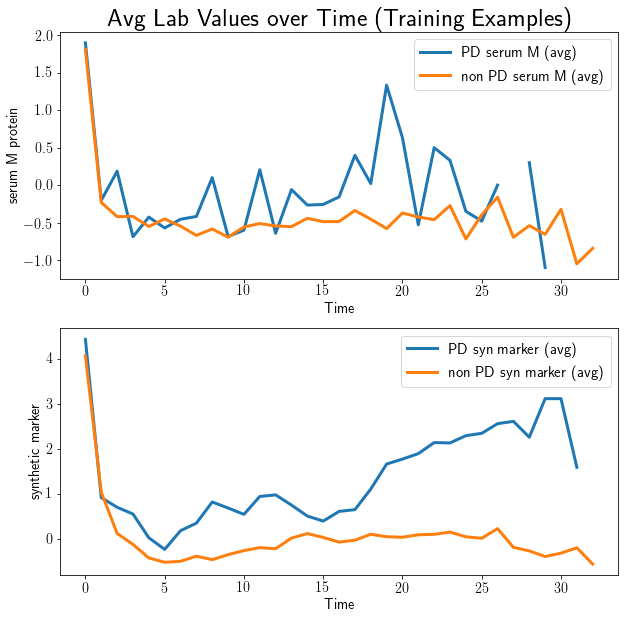

In [45]:
fig, axlist = plt.subplots(2,1,figsize=(10,10))
ax = axlist.ravel()
ax[0].plot(np.arange(pd_mprot.shape[1]),np.nanmean(pd_mprot, axis=0), linewidth=3, label='PD serum M (avg)')
ax[0].plot(np.arange(non_pd_mprot.shape[1]),np.nanmean(non_pd_mprot, axis=0), linewidth=3, label='non PD serum M (avg)')
# ax[0].fill_between(np.arange(pd_mprot.shape[1]), np.nanmean(pd_mprot,axis=0)-np.nanstd(pd_mprot,axis=0),np.nanmean(pd_mprot,axis=0)+np.nanstd(pd_mprot,axis=0), color='darkblue', alpha=0.4)
# ax[0].fill_between(np.arange(pd_mprot.shape[1]), np.nanmean(non_pd_mprot,axis=0)-np.nanstd(non_pd_mprot,axis=0),np.nanmean(non_pd_mprot,axis=0)+np.nanstd(non_pd_mprot,axis=0), color='orange', alpha=0.4)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('serum M protein')
ax[0].legend(fontsize=15)
ax[1].plot(np.arange(pd_syn_bio.shape[1]),np.nanmean(pd_syn_bio, axis=0), linewidth=3, label='PD syn marker (avg)')
ax[1].plot(np.arange(nonpd_syn_bio.shape[1]),np.nanmean(nonpd_syn_bio, axis=0), linewidth=3, label='non PD syn marker (avg)')
# ax[1].fill_between(np.arange(pd_syn_bio.shape[1]), np.nanmean(pd_syn_bio,axis=0)-np.nanstd(pd_syn_bio,axis=0),np.nanmean(pd_syn_bio,axis=0)+np.nanstd(pd_syn_bio,axis=0), color='darkblue', alpha=0.4)
# ax[1].fill_between(np.arange(pd_syn_bio.shape[1]), np.nanmean(nonpd_syn_bio,axis=0)-np.nanstd(nonpd_syn_bio,axis=0),np.nanmean(nonpd_syn_bio,axis=0)+np.nanstd(nonpd_syn_bio,axis=0), color='orange', alpha=0.4)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('synthetic marker')
ax[1].legend(fontsize=15)
ax[0].set_title('Avg Lab Values over Time (Training Examples)', fontsize=25)

(37, 33, 3)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


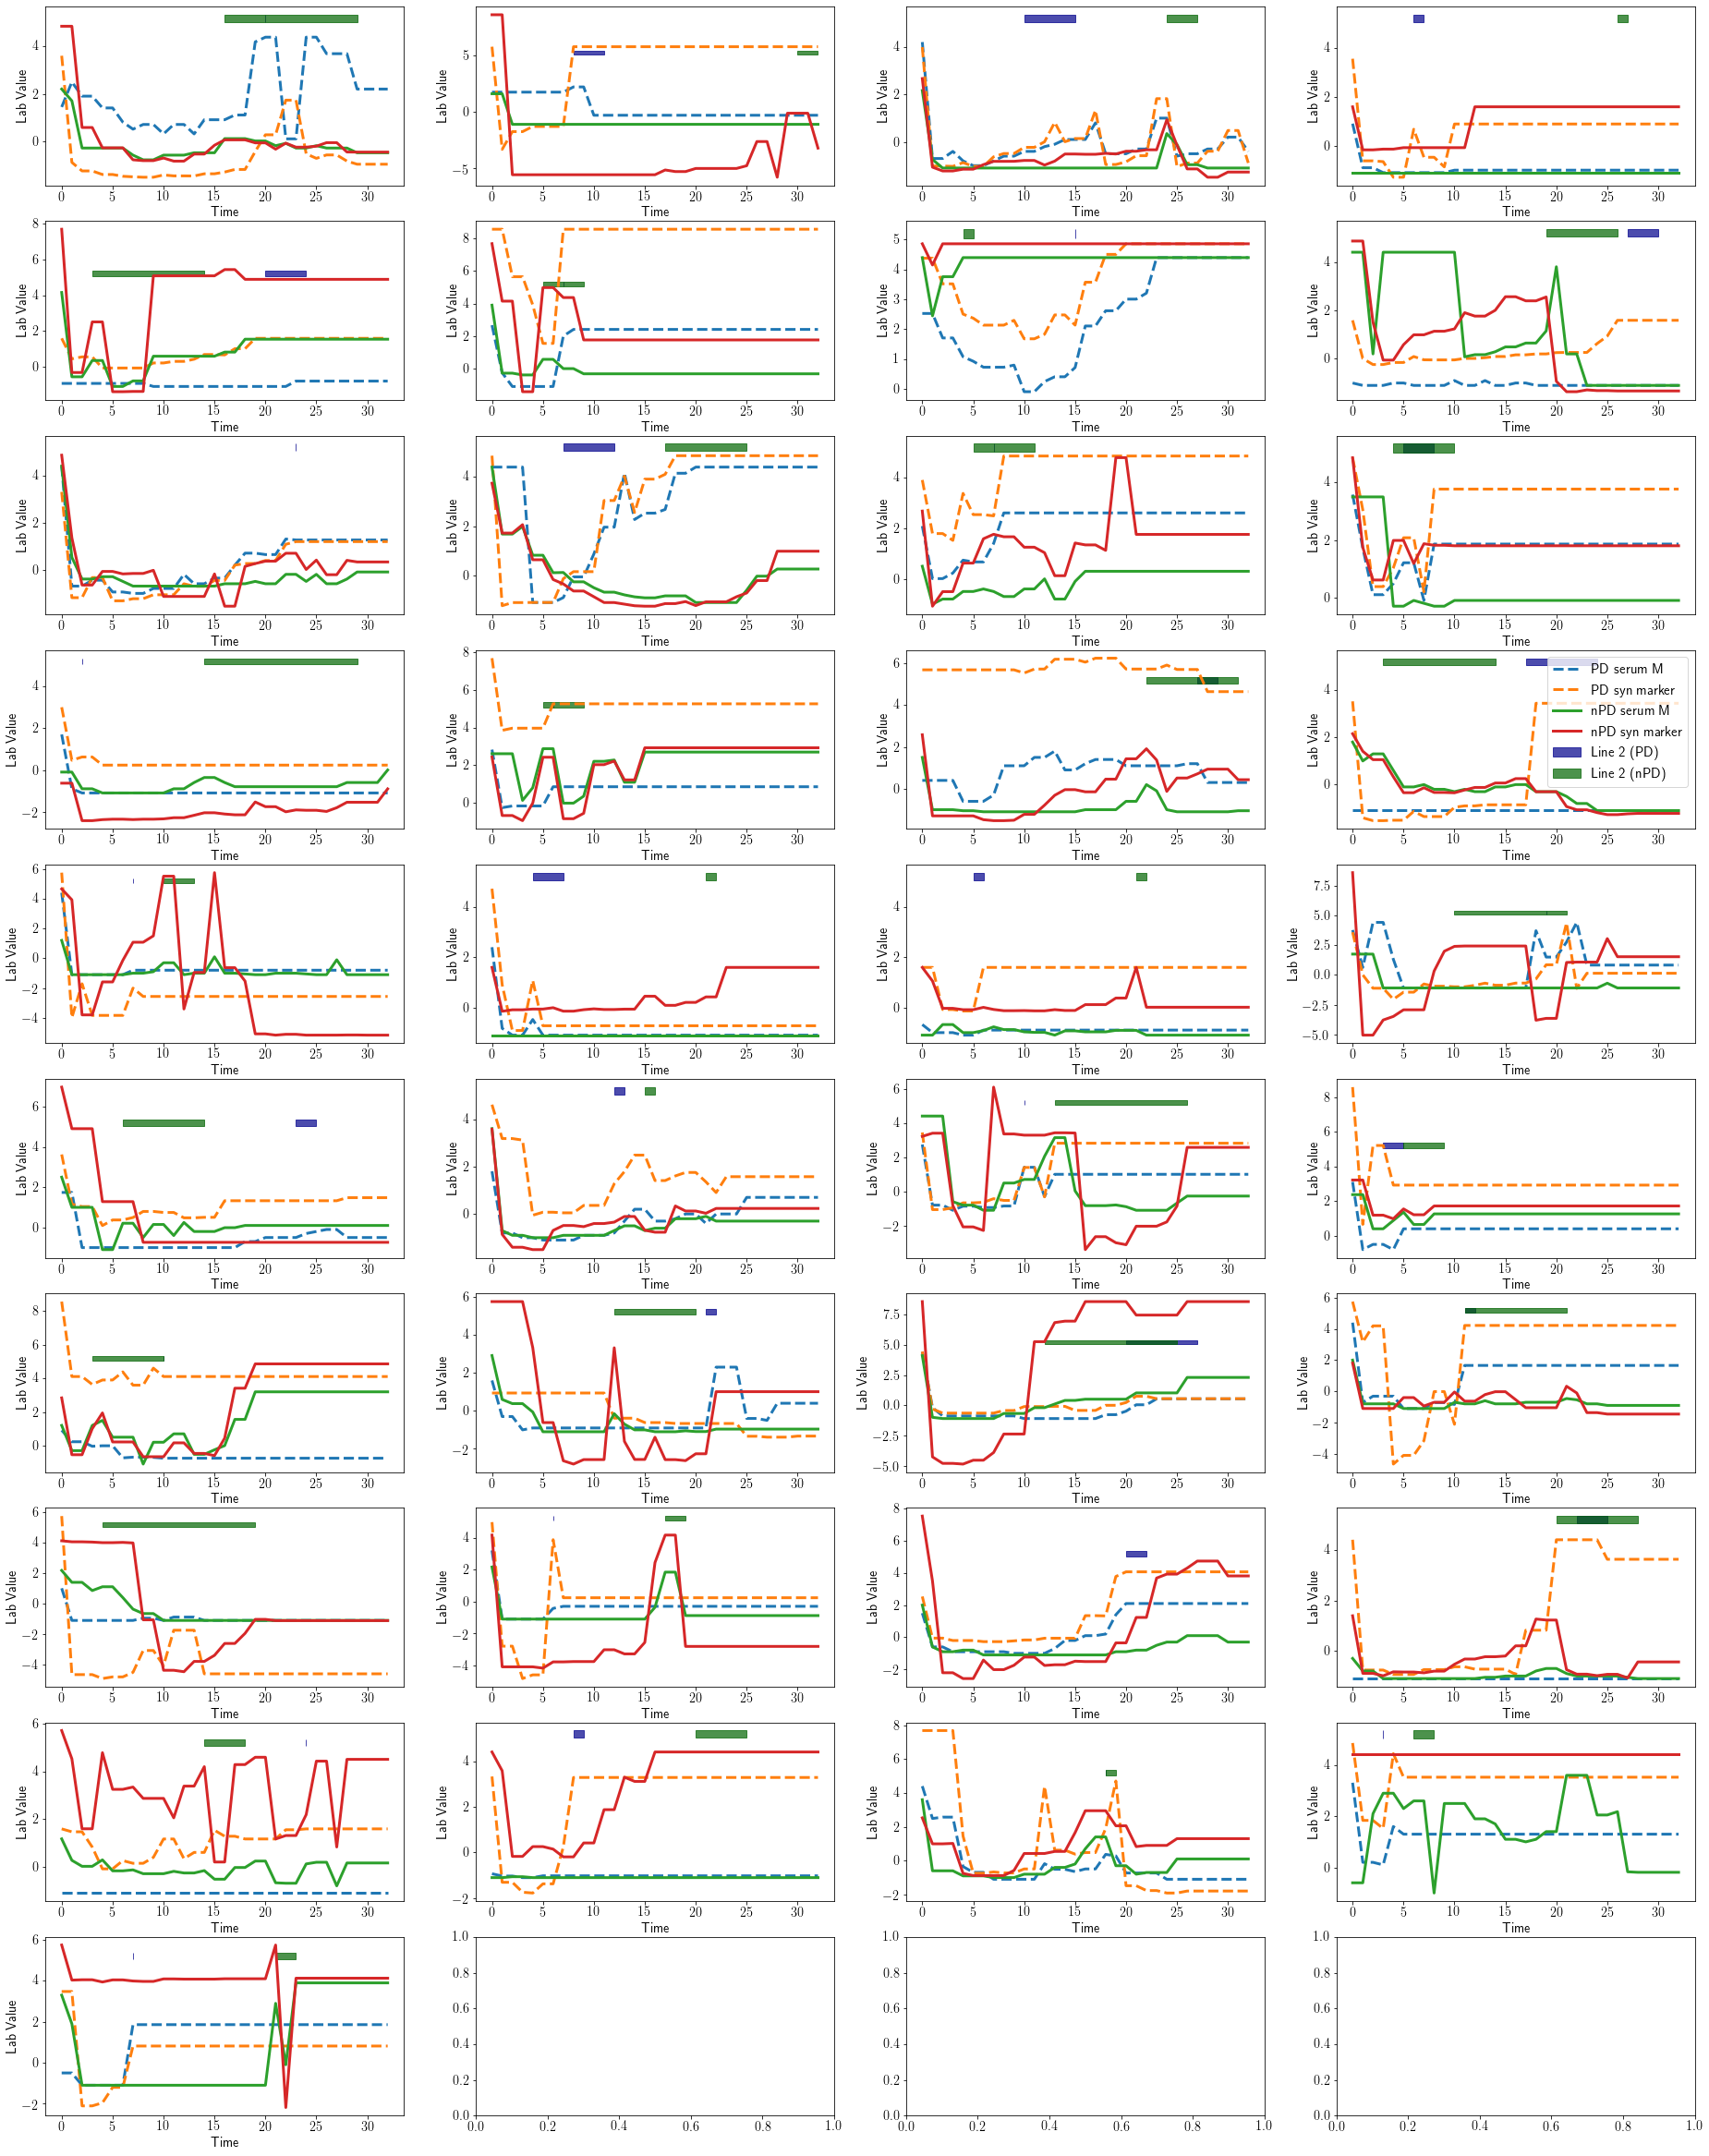

In [15]:
fig, axlist = plt.subplots(10,4,figsize=(32,42))
ax = axlist.ravel()
print(pd_line.shape)

for i in range(len(pd_pts)): 
#     s1 = 'PD serum M ' + str(ypid_trt[pd_pts[i]]); s2 = 'nPD serum M ' + str(ypid_trt[non_pd_pts[i]])
    print(i)
    lot2list_x = []; lot2list_y = []
    ymax = ax[i].get_ylim()[1]+0.05
#     print(pd_line[i].squeeze())
#     print(pd_syn_bio_m[i])
#     print(nonpd_syn_bio_m[i])
    for t in range(pd_line.shape[1]): 
        line = np.where(pd_line[i,t,:] == 1.)[0]+1
        if len(line) > 0 and line[0] == 2: 
            lot2list_x.append(t); lot2list_y.append(ymax+3.)
    if len(lot2list_x) != 0: 
        l = ax[i].fill_between(lot2list_x, np.array(lot2list_y)+1.,np.array(lot2list_y)+1.3, color='darkblue', alpha=0.7, label='Line 2 (PD)')
    
    lot2list_x = []; lot2list_y = []
    for t in range(non_pd_line.shape[1]): 
        line = np.where(non_pd_line[i,t,:] == 1.)[0]+1
        if len(line) > 0 and line[0] == 2: 
            lot2list_x.append(t); lot2list_y.append(ymax+3.)
    if len(lot2list_x) != 0: 
        l = ax[i].fill_between(lot2list_x, np.array(lot2list_y)+1.,np.array(lot2list_y)+1.3, color='darkgreen', alpha=0.7, label='Line 2 (nPD)')
                
    if i < pd_mprot.shape[0]: 
        ax[i].plot(np.arange(pd_mprot.shape[1]),pd_mprot[i,:], linestyle='--', linewidth=3,label='PD serum M')
        ax[i].plot(np.arange(pd_syn_bio.shape[1]),pd_syn_bio[i,:], linestyle='--', linewidth=3,label='PD syn marker')
        
#     ax[i].plot(np.arange(pd_mprot.shape[1]),pd_mprot[i,:,1], linestyle='--', linewidth=3, label= 'PD urine M')
    ax[i].plot(np.arange(non_pd_mprot.shape[1]),non_pd_mprot[i,:], linestyle='-', linewidth=3, label='nPD serum M')
    ax[i].plot(np.arange(nonpd_syn_bio.shape[1]),nonpd_syn_bio[i,:], linestyle='-', linewidth=3, label='nPD syn marker')
#     ax[i].plot(np.arange(non_pd_mprot.shape[1]),non_pd_mprot[i,:,1], linestyle='-', linewidth=3, label='nPD urine M')
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Lab Value')
    if i == 15: 
        ax[i].legend(fontsize=15)
    
# sns.distplot(new_dset['y_data'][new_dset['event_obs']==1],label='observed', ax = axlist, kde=False)
# sns.distplot(new_dset['y_data'][new_dset['event_obs']==0],label='censored', ax = axlist, kde=False)
# axlist.legend(fontsize=18)
# axlist.set_xlim([0,70])